---
title: "Analysis of the Thomas Fire"
description: " Boundary and True/False Color Mapping with Air Quality Index Analysis"
author: 
  - name: Michelle Yiv
    url: https://mmyiv.github.io
date: 2024-12-04
categories: [MEDS]
toc: true
csl: computational-biology-and-chemistry.csl
image: thomasfire.jpeg

---

# Analysis of the Thomas Fire: Boundary, True/False Color Mapping and Air Quality Index

Using CalFire, Landsat, and US EPA data to map the scars and air quality changes from the 2017 Thomas fire. 

Author: Michelle Yiv

For further information and content about this analysis, view this [GitHub repository.](https://github.com/mmyiv/eds220-hwk4)

![Thomas Fire above Santa Barbara City. Source: Independent.com](https://www.independent.com/wp-content/uploads/2017/12/13/MorganMaassen_2017_ThomasFire_-_3.jpg)

## This blog at a glance:

#### Purpose
The Thomas Fire burned 281,000 acres in Santa Barbara and Ventura County from December 4th to January 12, 2018. Approximately 1063 structures were consumed by the fire, and 2 people had lost their lives. It is currently the 10th largest wildfire in California.

We are visualizing the burn scars and air quality impact from the 2017 Thomas Fire in Santa Barbara.

Landsat data was used to visualize the Santa Barbara area and was combined with Thomas Fire data to map the fire's boundary. True and false color imagery was used to visualize burn scars, and air quality index data is used to further visualize the impact from the fire.

#### Datasets used

**1. California Fire Perimeter**

California fire perimeter was published by [CAL FIRE]((https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436)) and contains information about fires in California. In addition to the geometries (perimeters) of each fire, there is information about the name, date, and acres burned.

**2. Landsat data** 

Landsat was published by [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and contains both x,y coordinates and variables containing colors (R, G, B, NIR, SWIR) for plotting. This dataset contains the Santa Barbara location and surrounding areas. 

**3. Air Quality data**

Air quality data was published by the [US Environmental Protection Agency](https://www.epa.gov) and contains information about AQI values and its corresponding health concern category.

#### Analysis Highlights

- Plotting true and false color imagery of the Thomas fire. It's important to understand which bands to select to generate the respective images, and how false color emphasizes burn scars more than the true color. Packages used include 'rioxarray' to read in and utilize geospatial raster data.

- Cleaning the Air quality dataset by standardizing column names and dropping unnecessary columns. Although this may seem basic, emphasizing tidy data is important for future processing.

- Calculating a 5 day rolling average and plotting air quality index values. A rolling average is important because it de-emphasizes noise and brief fluctuations, allowing for clearer identification of trends. Packages used include 'pandas' to read in, tidy, and process data.


#### References to datasets
California Fire Perimeter.
Date of access: 11-19-2024.
[Link to data](https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436)
Citation: “Data.gov,” Data.gov, 2024. https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436 (accessed Nov. 19, 2024).

Landsat Data.
Date of access: 11-19-2024.
[Link to data](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)
Citation: “Microsoft Planetary Computer,” Microsoft.com, 2024. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2 (accessed Nov. 19, 2024).

Air Quality Index Data
Date of Access: 10-29-2024
[Link to data](https://www.airnow.gov/aqi/aqi-basics/)
Citation: "AQI Basics," airnow.gov, 2021. https://www.airnow.gov/aqi/aqi-basics/ (accesed Oct. 29, 2024)

## A guide to this blog

I thought that I would include a general guide to how I will be structuring this blog analysis. Since we are working with multiple datasets, I will break this up into sections and gradually introduce the datasets.

I will start by loading all packages here to follow good coding practices.

## Initial setup for all datasets

### Load packages

In [3]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt

## Retreiving the boundary of the 2017 Thomas Fire

Let's start by getting the Thomas Fire boundary data. I manually downloaded boundary data of all fires in California, placed it into my data folder, and read it in using an absolute file path and the `geoPandas` package because it is a shapefile. I saved this data to a new variable named 'fire'.

In [4]:
fp = os.path.join('data', 'California_Fire_Perimeters_(all).shp')
fire = gpd.read_file(fp)

However, we only want the boundary from the 2017 Thomas fire. Therefore, I filtered by both name **and** year because there have been multiple Thomas Fires, and saved to a new variable named 'thomas_fire'. To check if the data was filtered properly, I made an initial plot.

<AxesSubplot:>

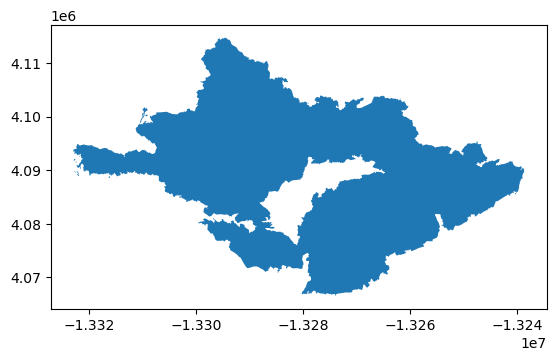

In [5]:
# Select 2017 Thomas Fire boundary by name and year
thomas_fire = fire[(fire['FIRE_NAME']=='THOMAS') & (fire['YEAR_']==2017)]

# Verify changes visually
thomas_fire.plot()

It worked! We will come back to this boundary later to add to our maps in the next section.

## True and False Color Imagery of the Thomas Fire

Let's load in our data for our color imagery now! This data was sourced by the course instructor and is housed on their server. I accessed it by creating an absolute file and reading it in using the `rioxarray` package because we are now working with geospatial raster data.

In [6]:
# Create filepath to import landsat data
fp = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'hwk4_landsat_data',
                  'landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(fp)

Let's see what our data looks like:

In [7]:
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

Our data comes out as an `xarray.Dataset`, with its dimensions (y, x, band) and Data variables containing our colors for plotting. We've read in and verified our data, so now let's do something with it!

Notice how we only have a single band. We want to drop this because we don;t need that extra dimension. We do this using [`squeeze()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.squeeze.html) as seen here, and to remove the variable we use [`drop_vars()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.drop_vars.html). It's aptly named!

In [8]:
landsat = landsat.squeeze().drop_vars('band')

### True color image

Let's start with a true color image: We will select red, green, and blue colors to make an image you would see out in the real world.

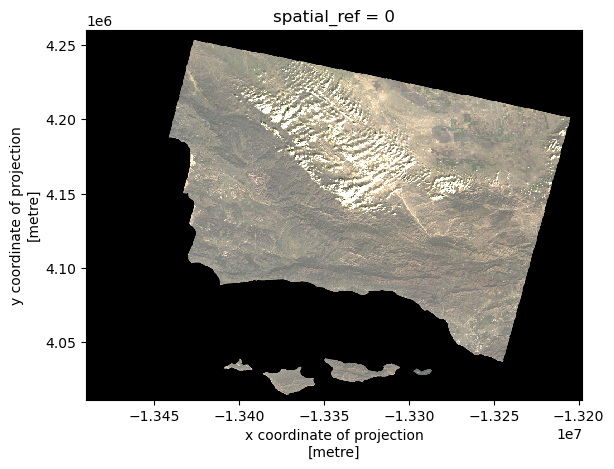

In [16]:
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

Aside from how it floats in space, it looks great, right? Now, how did we actually plot this?
Using our raster data, we select for red, green, and blue as indicated by the double brackets. We method chain into `to_array()`, which converts the data to a `numpyArray`. This can then be plotted using [`.plot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), which is used for plotting 2D scalar data.

What is this `robust=True` parameter? Let's see how it looks when we omit it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


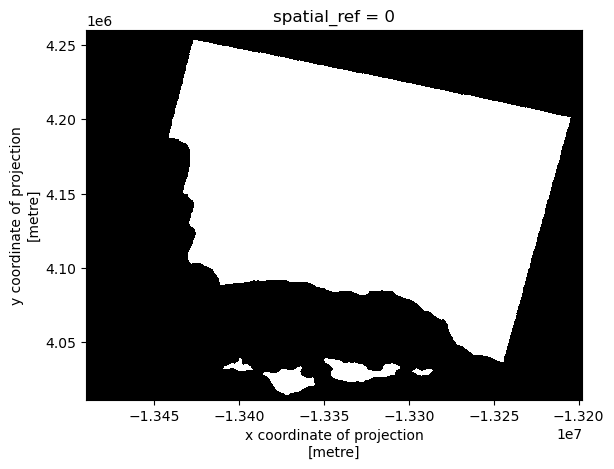

In [18]:
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

Scary, right! Clearly, we can see a difference from the previous plot, but we also get an error message. What this `robust` parameter does is visualize the plot *without* RBG outliers from the clouds. Here, the other values are being so squished together that a plot like this is created.

### False color image

Let's transition to a false color image now. Wait, what? FALSE color?
Look for yourself. Could you distinguish the burned area from the Thomas Fire? Me either. This is why false color imagery exits. Using a combination of these selected colors can highlight features that may be overlooked on a true color image. So, we will follow a similar format for code as above, but we will simply use short wave infrared (swir22), near infrared (nir08), and read as out color variables instead.

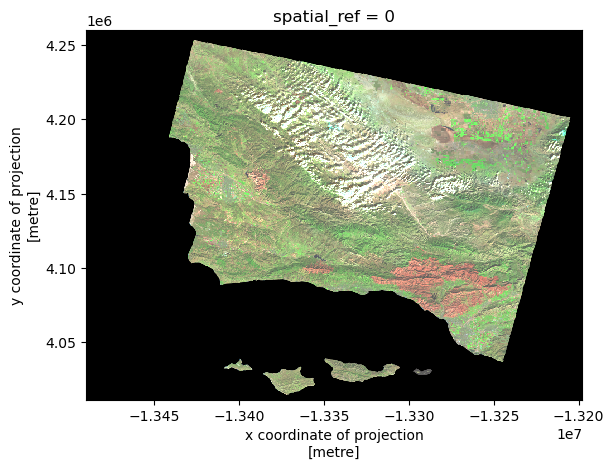

In [20]:
# Make false color by plotting swir22, NIR, and red
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

It worked! And the burn scars from the Thomas fire are visible now! In case you missed it, it is the red shaded portion located near the Santa Barbara or lower right portion of the plot, in case you are map illiterate like me. 
Now, I could be happy with this map, however I would like to use that boundary data we got earlier and put it on this plot.

## Mapping Thomas Fire boundary onto false color image

In [11]:
# Check CRS of both data sets
print(f"{'Landsat CRS is':<10} {landsat.rio.crs}")
print(f"{'Fire CRS is':<10} {fire.crs}")

Landsat CRS is EPSG:32611
Fire CRS is epsg:3857


In [12]:
# Convert CRS of landsat to thomas_fire
landsat = landsat.rio.reproject("EPSG:3857")

# Verify CRS match
assert landsat.rio.crs == thomas_fire.crs

In [22]:
# Clip landsat data to the bounds of thomas fire
landsat_fire = landsat.rio.clip_box(*thomas_fire.total_bounds)

/tmp/ipykernel_3669961/1010408731.py:15: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(thomas_fire, labels = ['2017 Thomas Fire Boundary'])


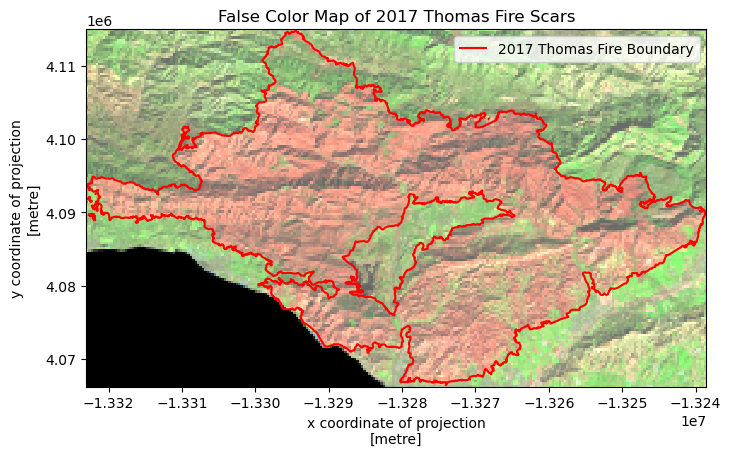

In [23]:
# Map of SWIR/NIR/RED with Thomas fire + figure description

# Initialize plot
fig, ax = plt.subplots(figsize = (8,8))

# Landsat clipped plot
landsat_fire[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, robust = True)

# Thomas fire boundary
thomas_fire.boundary.plot(ax = ax,
                         color = 'red',
                         linewidth = 1.5,
                         label = 'Thomas Fire Boundary')

plt.legend(thomas_fire, labels = ['2017 Thomas Fire Boundary'])

# Set title
ax.set_title('False Color Map of 2017 Thomas Fire Scars')

plt.show()

## Air Quality Index analysis 

In [26]:
aqi_17 = pd.read_csv('data/daily_aqi_by_county_2017.csv')
aqi_17 = pd.read_csv('data/daily_aqi_by_county_2018.csv')

In [24]:
# Read in data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip', compression='zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

HTTPError: HTTP Error 503: Service Unavailable

In [ ]:
# Stack data frames into one 
aqi = pd.concat([aqi_17, aqi_18])

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_'))

# Filter data to Santa Barbara County
aqi_sb = aqi[aqi['county_name']=='Santa Barbara']

# Drop columns from data: State and county name and code
aqi_sb = aqi_sb.drop(columns=['state_name', 'county_name', 'state_code','county_code'])

# Update the date column type to datetime format
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])

# Set index to date column
aqi_sb = aqi_sb.set_index('date')

# Calculate AQI rolling average over 5 days
rolling_average = aqi_sb['aqi'].rolling('5D').mean()

# Add rolling average as a new column
aqi_sb['five_day_average'] = rolling_average

# Make plot of AQis by date
aqi_sb.plot(kind = 'line',
            y = ['aqi', 'five_day_average'],
            title = "AQI and 5 Day Average AQI",
            color=['orange', 'green']
).set_xlabel("Date")